# EDA - Análisis Exploratorio de Landmarks
**Sistema de Anotación de Video - Entrega 1**

Este notebook realiza el análisis exploratorio de los datos de landmarks extraídos con MediaPipe.

## Dataset Disponible:
- **📁 45 archivos CSV** con landmarks  
- **🎬 5 actividades** diferentes
- **📊 16 landmarks** por frame (64 coordenadas)

## Análisis a Realizar:
1. Cargar y explorar datos
2. Limpiar frames sin detección  
3. Visualizar patrones por actividad
4. Análisis estadístico
5. Preparar para modelado

---


## Paso 1: Instalación y Setup
Instalar librerías necesarias para análisis y visualización.


In [7]:
# Instalar dependencias para EDA
!pip install pandas numpy matplotlib seaborn plotly scikit-learn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
import os
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerías cargadas para EDA")
print(f"📊 Pandas: {pd.__version__}")

✅ Librerías cargadas para EDA
📊 Pandas: 2.2.2


## Paso 2: Cargar Todos los Datos
Cargar y combinar todos los archivos CSV de landmarks en un solo DataFrame.


In [6]:
# CARGAR TODOS LOS CSVs DE LANDMARKS
def load_all_landmarks():
    """Cargar todos los archivos CSV de landmarks"""
    print("📂 CARGANDO TODOS LOS ARCHIVOS DE LANDMARKS")
    print("=" * 50)

    landmarks_dir = Path('/content/')

    if not landmarks_dir.exists():
        print(f"❌ Directorio no encontrado: {landmarks_dir}")
        return None

    # Encontrar todos los CSVs
    csv_files = list(landmarks_dir.glob("*.csv"))

    if not csv_files:
        print("❌ No se encontraron archivos CSV")
        return None

    print(f"📁 Archivos encontrados: {len(csv_files)}")

    all_dataframes = []
    loading_stats = {'loaded': 0, 'errors': 0, 'total_frames': 0}

    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            all_dataframes.append(df)
            loading_stats['loaded'] += 1
            loading_stats['total_frames'] += len(df)

            print(f"   ✅ {csv_file.name}: {len(df)} frames")

        except Exception as e:
            loading_stats['errors'] += 1
            print(f"   ❌ Error en {csv_file.name}: {e}")

    if not all_dataframes:
        print("❌ No se pudieron cargar datos")
        return None

    # Combinar todos los DataFrames
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    print(f"\n📊 RESUMEN DE CARGA:")
    print(f"   ✅ Archivos cargados: {loading_stats['loaded']}")
    print(f"   ❌ Errores: {loading_stats['errors']}")
    print(f"   📊 Total frames: {loading_stats['total_frames']:,}")
    print(f"   🎬 Videos únicos: {combined_df['video_file'].nunique()}")
    print(f"   🎯 Actividades: {combined_df['activity'].nunique()}")

    return combined_df

# Cargar datos
df_landmarks = load_all_landmarks()

if df_landmarks is not None:
    print(f"\n✅ DATOS CARGADOS EXITOSAMENTE")
    print(f"   📐 Dimensiones: {df_landmarks.shape}")
else:
    print(f"\n❌ ERROR CARGANDO DATOS")

📂 CARGANDO TODOS LOS ARCHIVOS DE LANDMARKS
📁 Archivos encontrados: 45
   ✅ caminar_hacia_005_landmarks.csv: 95 frames
   ✅ girar_006_landmarks.csv: 124 frames
   ✅ ponerse_pie_003_landmarks.csv: 79 frames
   ✅ girar_003_landmarks.csv: 122 frames
   ✅ girar_007_landmarks.csv: 139 frames
   ✅ ponerse_pie_001_landmarks.csv: 74 frames
   ✅ caminar_hacia_009_landmarks.csv: 115 frames
   ✅ sentarse_006_landmarks.csv: 107 frames
   ✅ ponerse_pie_006_landmarks.csv: 140 frames
   ✅ caminar_hacia_003_landmarks.csv: 95 frames
   ✅ ponerse_pie_009_landmarks.csv: 75 frames
   ✅ sentarse_004_landmarks.csv: 79 frames
   ✅ sentarse_008_landmarks.csv: 79 frames
   ✅ caminar_hacia_007_landmarks.csv: 117 frames
   ✅ girar_001_landmarks.csv: 134 frames
   ✅ sentarse_002_landmarks.csv: 73 frames
   ✅ caminar_regreso_001_landmarks.csv: 107 frames
   ✅ caminar_regreso_010_landmarks.csv: 132 frames
   ✅ girar_002_landmarks.csv: 130 frames
   ✅ caminar_hacia_001_landmarks.csv: 128 frames
   ✅ ponerse_pie_002_l

## Paso 3: Limpiar Datos (Opcional)
Filtrar frames donde MediaPipe no detectó persona para análisis más limpio.


In [8]:
# LIMPIAR DATOS - FILTRAR FRAMES SIN DETECCIÓN
def clean_zero_frames(df):
    """Filtrar frames donde MediaPipe no detectó landmarks"""
    print("🧹 LIMPIANDO FRAMES SIN DETECCIÓN")
    print("=" * 40)

    # Identificar columnas de landmarks
    landmark_cols = [col for col in df.columns if col not in ['activity', 'video_file', 'frame_number']]

    print(f"📊 ANTES DE LIMPIEZA:")
    print(f"   Total frames: {len(df):,}")

    # Contar frames con solo ceros
    zero_frames = df[(df[landmark_cols] == 0.0).all(axis=1)]
    detected_frames = df[(df[landmark_cols] != 0.0).any(axis=1)]

    print(f"   ❌ Frames sin detección: {len(zero_frames):,} ({len(zero_frames)/len(df)*100:.1f}%)")
    print(f"   ✅ Frames con detección: {len(detected_frames):,} ({len(detected_frames)/len(df)*100:.1f}%)")

    # Mostrar distribución por actividad
    print(f"\n📊 DETECCIÓN POR ACTIVIDAD:")
    for activity in df['activity'].unique():
        activity_data = df[df['activity'] == activity]
        activity_detected = activity_data[(activity_data[landmark_cols] != 0.0).any(axis=1)]
        detection_rate = len(activity_detected) / len(activity_data) * 100

        print(f"   {activity.replace('_', ' ').title()}: {detection_rate:.1f}% detección")

    # Crear versión limpia
    df_clean = detected_frames.copy().reset_index(drop=True)

    print(f"\n🧹 DESPUÉS DE LIMPIEZA:")
    print(f"   Total frames: {len(df_clean):,}")
    print(f"   Reducción: {len(df) - len(df_clean):,} frames eliminados")
    print(f"   📈 Eficiencia: {len(df_clean)/len(df)*100:.1f}%")

    # Verificar que todas las actividades siguen representadas
    print(f"\n🎯 VERIFICACIÓN POR ACTIVIDAD:")
    for activity in df['activity'].unique():
        count = len(df_clean[df_clean['activity'] == activity])
        print(f"   {activity.replace('_', ' ').title()}: {count:,} frames")

    return df_clean

# Limpiar datos
if df_landmarks is not None:
    df_clean = clean_zero_frames(df_landmarks)

    # Usar datos limpios para el resto del análisis
    df = df_clean
    print(f"\n✅ DATOS LIMPIOS LISTOS PARA EDA")
else:
    print("❌ No hay datos para limpiar")


🧹 LIMPIANDO FRAMES SIN DETECCIÓN
📊 ANTES DE LIMPIEZA:
   Total frames: 4,751
   ❌ Frames sin detección: 176 (3.7%)
   ✅ Frames con detección: 4,575 (96.3%)

📊 DETECCIÓN POR ACTIVIDAD:
   Caminar Hacia: 99.7% detección
   Girar: 100.0% detección
   Ponerse Pie: 100.0% detección
   Sentarse: 99.8% detección
   Caminar Regreso: 85.8% detección

🧹 DESPUÉS DE LIMPIEZA:
   Total frames: 4,575
   Reducción: 176 frames eliminados
   📈 Eficiencia: 96.3%

🎯 VERIFICACIÓN POR ACTIVIDAD:
   Caminar Hacia: 991 frames
   Girar: 1,089 frames
   Ponerse Pie: 809 frames
   Sentarse: 645 frames
   Caminar Regreso: 1,041 frames

✅ DATOS LIMPIOS LISTOS PARA EDA


## Paso 4: Análisis Exploratorio Básico
Estadísticas descriptivas y distribuciones del dataset.


In [9]:
# ANÁLISIS EXPLORATORIO BÁSICO
def basic_exploratory_analysis(df):
    """Análisis exploratorio básico del dataset"""
    print("📊 ANÁLISIS EXPLORATORIO BÁSICO")
    print("=" * 40)

    # Información general
    print(f"📋 INFORMACIÓN GENERAL:")
    print(f"   Frames totales: {len(df):,}")
    print(f"   Videos únicos: {df['video_file'].nunique()}")
    print(f"   Actividades: {df['activity'].nunique()}")
    print(f"   Columnas: {len(df.columns)}")

    # Distribución por actividad
    print(f"\n🎯 DISTRIBUCIÓN POR ACTIVIDAD:")
    activity_counts = df['activity'].value_counts()
    for activity, count in activity_counts.items():
        percentage = count / len(df) * 100
        print(f"   {activity.replace('_', ' ').title()}: {count:,} frames ({percentage:.1f}%)")

    # Estadísticas de duración por video
    print(f"\n⏱️ ESTADÍSTICAS DE DURACIÓN:")
    video_durations = df.groupby('video_file').size()
    print(f"   Promedio frames por video: {video_durations.mean():.0f}")
    print(f"   Mediana: {video_durations.median():.0f}")
    print(f"   Min/Max: {video_durations.min()} / {video_durations.max()}")

    # Balance del dataset
    balance_ratio = activity_counts.min() / activity_counts.max()
    print(f"\n⚖️ BALANCE DEL DATASET:")
    print(f"   Ratio balance: {balance_ratio:.2f}")
    print(f"   Estado: {'✅ BALANCEADO' if balance_ratio > 0.7 else '⚠️ DESBALANCEADO'}")

    return {
        'total_frames': len(df),
        'unique_videos': df['video_file'].nunique(),
        'activity_distribution': activity_counts.to_dict(),
        'balance_ratio': balance_ratio
    }

if df_landmarks is not None:
    basic_stats = basic_exploratory_analysis(df)
else:
    print("❌ No hay datos para análisis básico")


📊 ANÁLISIS EXPLORATORIO BÁSICO
📋 INFORMACIÓN GENERAL:
   Frames totales: 4,575
   Videos únicos: 45
   Actividades: 5
   Columnas: 67

🎯 DISTRIBUCIÓN POR ACTIVIDAD:
   Girar: 1,089 frames (23.8%)
   Caminar Regreso: 1,041 frames (22.8%)
   Caminar Hacia: 991 frames (21.7%)
   Ponerse Pie: 809 frames (17.7%)
   Sentarse: 645 frames (14.1%)

⏱️ ESTADÍSTICAS DE DURACIÓN:
   Promedio frames por video: 102
   Mediana: 104
   Min/Max: 58 / 156

⚖️ BALANCE DEL DATASET:
   Ratio balance: 0.59
   Estado: ⚠️ DESBALANCEADO


## Paso 5: Visualizaciones de Distribución
Crear gráficos para visualizar la distribución de datos por actividad.


📊 CREANDO VISUALIZACIONES DE DISTRIBUCIÓN


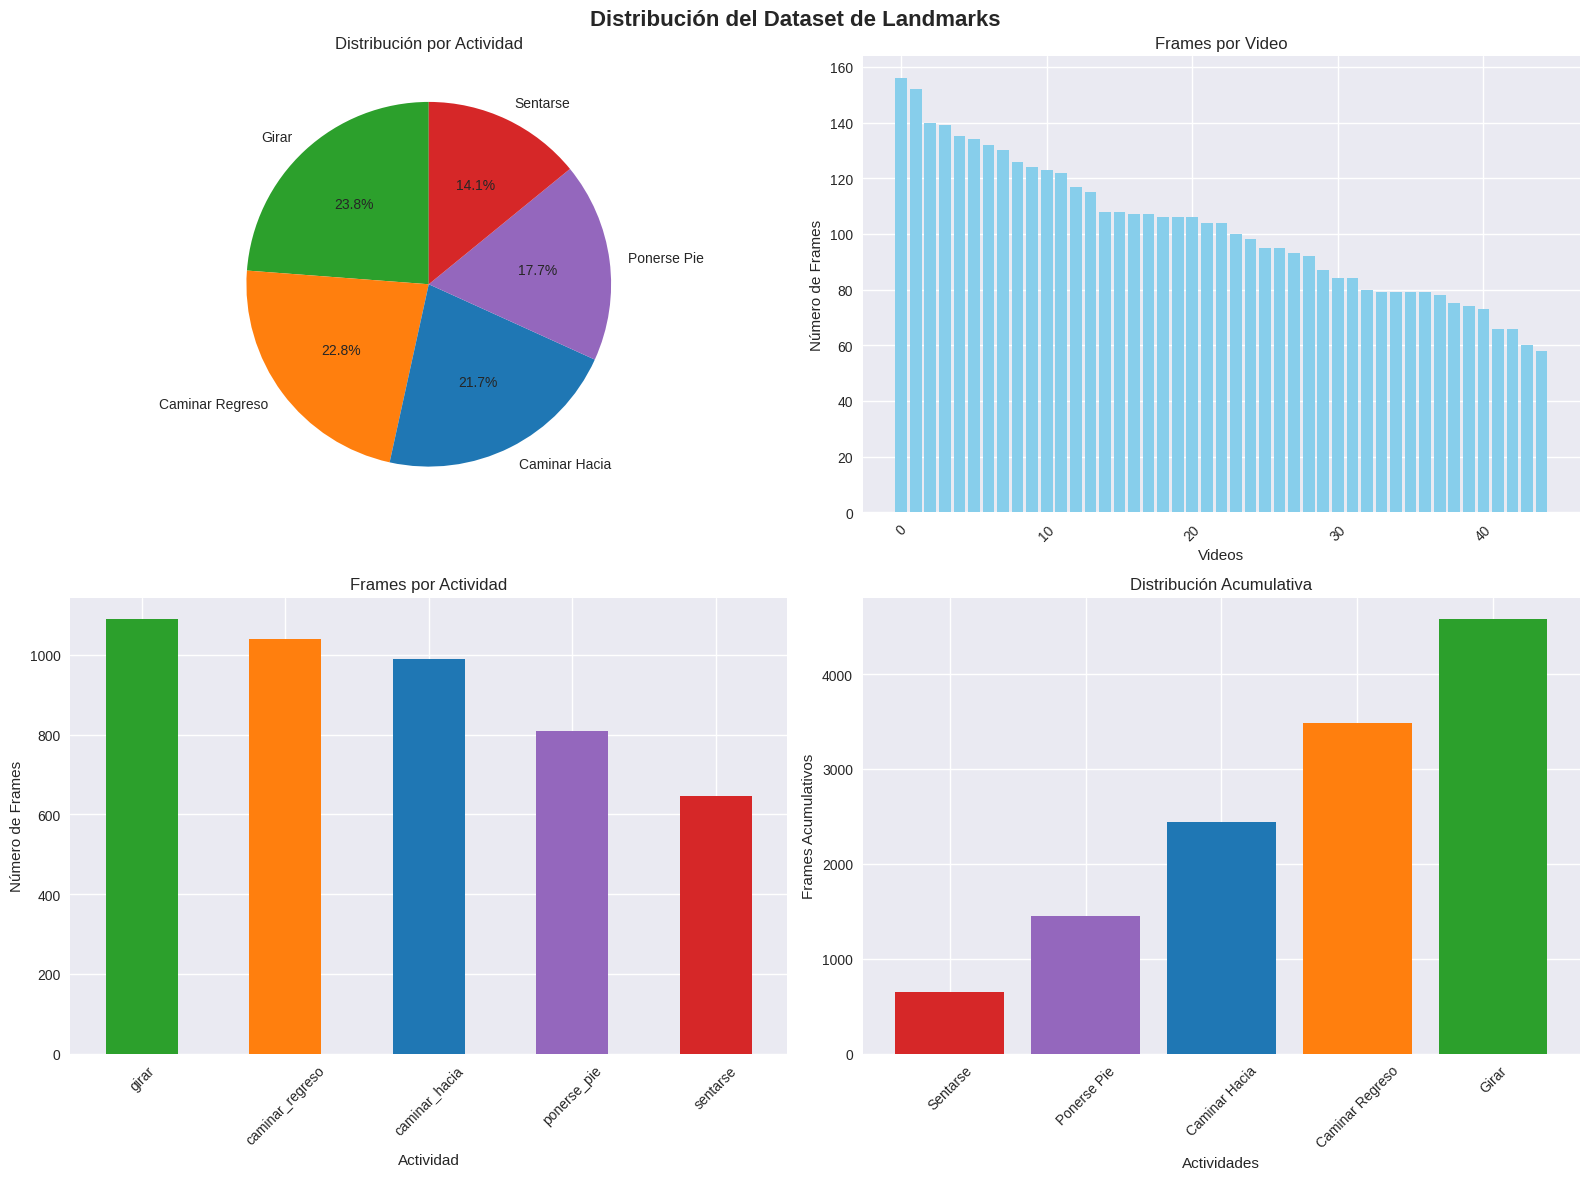

In [10]:
# VISUALIZACIONES DE DISTRIBUCIÓN
def create_distribution_plots(df):
    """Crear visualizaciones de distribución del dataset"""
    print("📊 CREANDO VISUALIZACIONES DE DISTRIBUCIÓN")
    print("=" * 50)

    # Configurar colores por actividad
    activity_colors = {
        'caminar_hacia': '#1f77b4',
        'caminar_regreso': '#ff7f0e',
        'girar': '#2ca02c',
        'sentarse': '#d62728',
        'ponerse_pie': '#9467bd'
    }

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Distribución del Dataset de Landmarks', fontsize=16, fontweight='bold')

    # 1. Distribución por actividad (pie chart)
    activity_counts = df['activity'].value_counts()
    colors = [activity_colors.get(act, 'gray') for act in activity_counts.index]

    axes[0,0].pie(activity_counts.values,
                  labels=[act.replace('_', ' ').title() for act in activity_counts.index],
                  autopct='%1.1f%%',
                  colors=colors,
                  startangle=90)
    axes[0,0].set_title('Distribución por Actividad')

    # 2. Frames por video
    video_frames = df.groupby('video_file').size().sort_values(ascending=False)
    axes[0,1].bar(range(len(video_frames)), video_frames.values, color='skyblue')
    axes[0,1].set_title('Frames por Video')
    axes[0,1].set_xlabel('Videos')
    axes[0,1].set_ylabel('Número de Frames')
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. Distribución de frames por actividad (barras)
    activity_counts.plot(kind='bar', ax=axes[1,0],
                        color=[activity_colors.get(act, 'gray') for act in activity_counts.index])
    axes[1,0].set_title('Frames por Actividad')
    axes[1,0].set_xlabel('Actividad')
    axes[1,0].set_ylabel('Número de Frames')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 4. Distribución acumulativa
    sorted_activities = df['activity'].value_counts().sort_values(ascending=True)
    cumulative = np.cumsum(sorted_activities.values)

    axes[1,1].bar(range(len(sorted_activities)), cumulative,
                  color=[activity_colors.get(act, 'gray') for act in sorted_activities.index])
    axes[1,1].set_title('Distribución Acumulativa')
    axes[1,1].set_xlabel('Actividades')
    axes[1,1].set_ylabel('Frames Acumulativos')
    axes[1,1].set_xticks(range(len(sorted_activities)))
    axes[1,1].set_xticklabels([act.replace('_', ' ').title() for act in sorted_activities.index],
                             rotation=45)

    plt.tight_layout()

    # Guardar figura
    os.makedirs('data/eda_results', exist_ok=True)
    plt.savefig('data/eda_results/distribucion_dataset.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

if df_landmarks is not None:
    distribution_plots = create_distribution_plots(df)
else:
    print("❌ No hay datos para visualizar")


## Paso 6: Análisis de Landmarks por Actividad
Analizar patrones de movimiento específicos de cada actividad.


🎯 ANÁLISIS DE LANDMARKS POR ACTIVIDAD


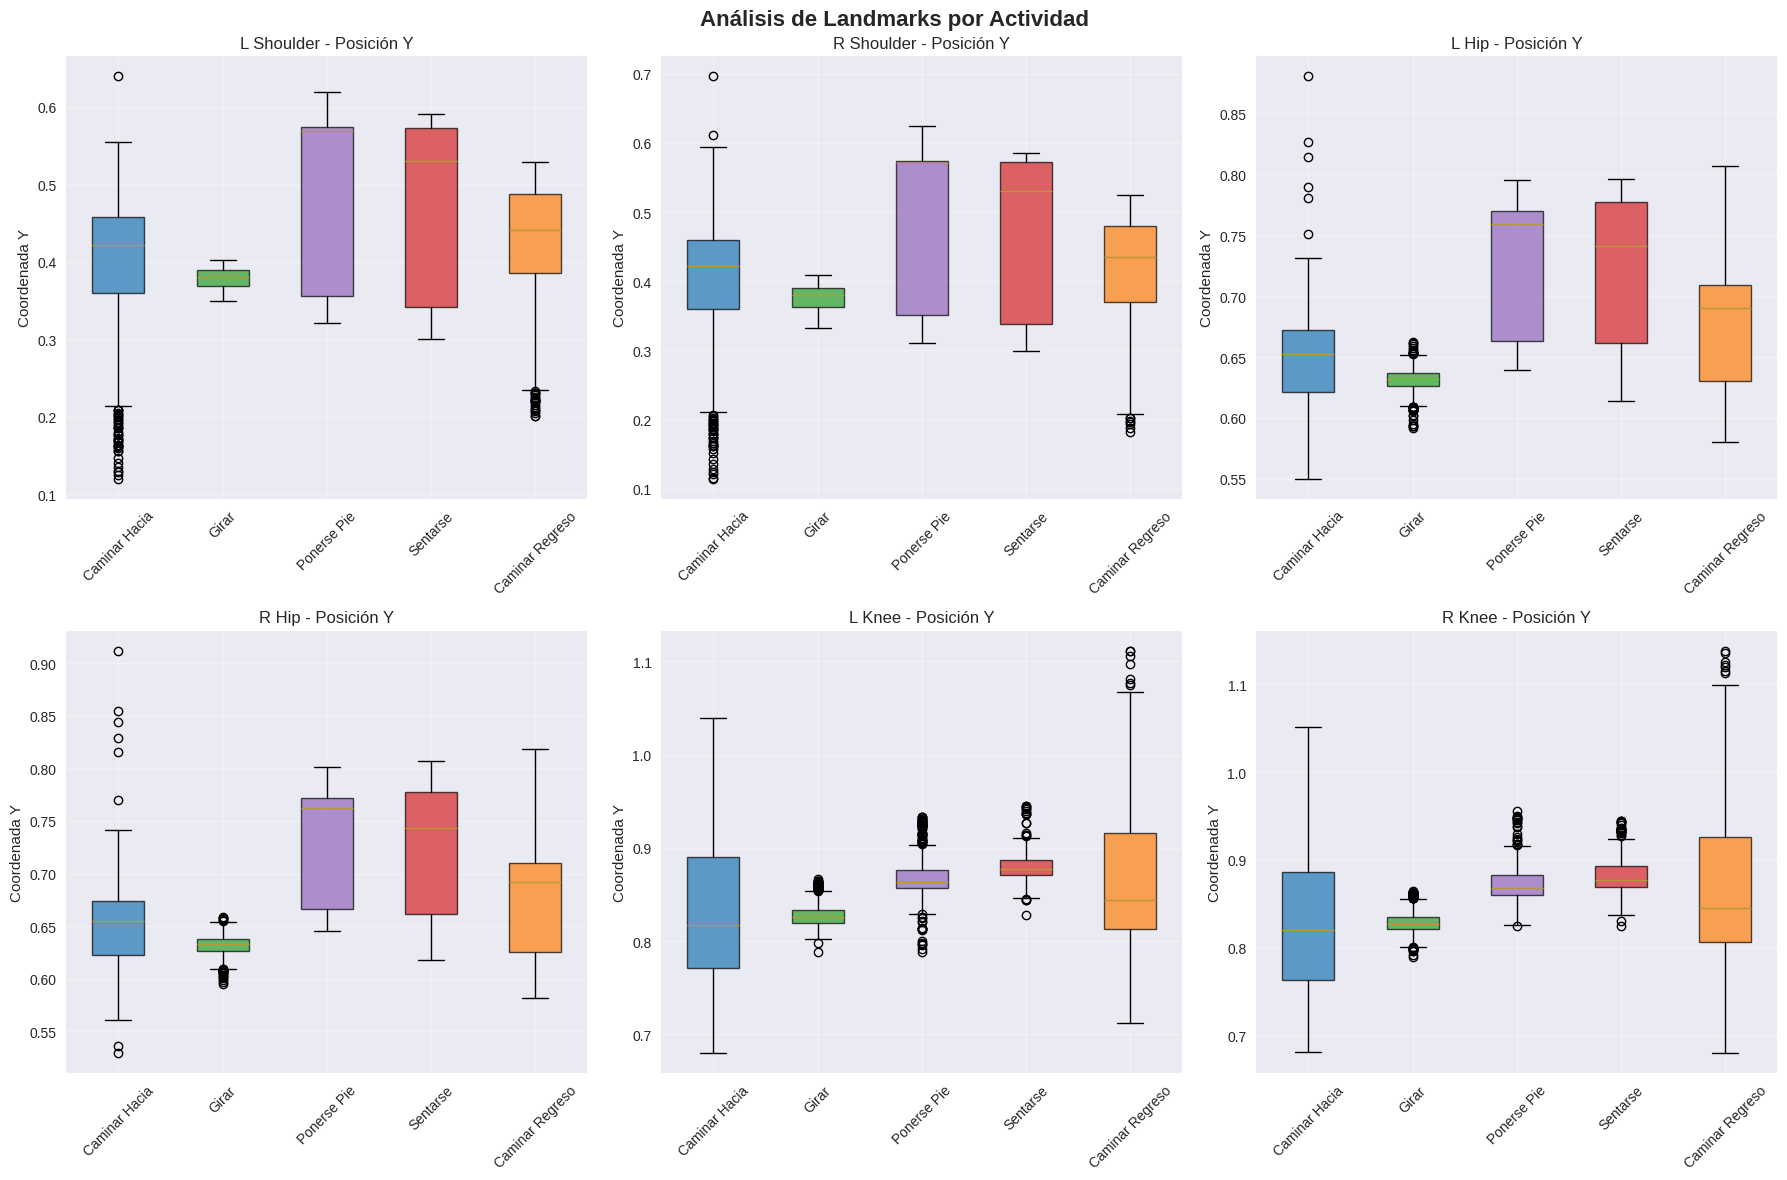


📊 ESTADÍSTICAS DE LANDMARKS:

🎯 L Shoulder (Y):
   Caminar Hacia: μ=0.402, σ=0.083
   Caminar Regreso: μ=0.426, σ=0.078
   Girar: μ=0.379, σ=0.013
   Ponerse Pie: μ=0.496, σ=0.105
   Sentarse: μ=0.471, σ=0.110

🎯 R Shoulder (Y):
   Caminar Hacia: μ=0.401, σ=0.083
   Caminar Regreso: μ=0.415, σ=0.082
   Girar: μ=0.377, σ=0.017
   Ponerse Pie: μ=0.494, σ=0.106
   Sentarse: μ=0.469, σ=0.110

🎯 L Hip (Y):
   Caminar Hacia: μ=0.646, σ=0.039
   Caminar Regreso: μ=0.682, σ=0.049
   Girar: μ=0.631, σ=0.010
   Ponerse Pie: μ=0.728, σ=0.052
   Sentarse: μ=0.724, σ=0.057

🎯 R Hip (Y):
   Caminar Hacia: μ=0.649, σ=0.040
   Caminar Regreso: μ=0.682, σ=0.051
   Girar: μ=0.631, σ=0.010
   Ponerse Pie: μ=0.731, σ=0.051
   Sentarse: μ=0.726, σ=0.057

🎯 L Knee (Y):
   Caminar Hacia: μ=0.831, σ=0.080
   Caminar Regreso: μ=0.856, σ=0.079
   Girar: μ=0.828, σ=0.012
   Ponerse Pie: μ=0.867, σ=0.020
   Sentarse: μ=0.879, σ=0.015

🎯 R Knee (Y):
   Caminar Hacia: μ=0.832, σ=0.080
   Caminar Regreso: μ=0.863, 

In [11]:
# ANÁLISIS DE LANDMARKS POR ACTIVIDAD
def analyze_landmarks_by_activity(df):
    """Analizar patrones de landmarks por cada actividad"""
    print("🎯 ANÁLISIS DE LANDMARKS POR ACTIVIDAD")
    print("=" * 50)

    # Columnas de landmarks
    landmark_cols = [col for col in df.columns if col not in ['activity', 'video_file', 'frame_number']]

    # Landmarks principales para análisis
    key_landmarks = ['L_shoulder', 'R_shoulder', 'L_hip', 'R_hip', 'L_knee', 'R_knee']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análisis de Landmarks por Actividad', fontsize=16, fontweight='bold')

    activity_colors = {
        'caminar_hacia': '#1f77b4',
        'caminar_regreso': '#ff7f0e',
        'girar': '#2ca02c',
        'sentarse': '#d62728',
        'ponerse_pie': '#9467bd'
    }

    # Analizar cada landmark clave
    for i, landmark in enumerate(key_landmarks):
        row = i // 3
        col = i % 3

        # Analizar coordenada Y (vertical) - más discriminativa
        y_col = f"{landmark}_y"

        if y_col in df.columns:
            # Crear boxplot por actividad
            activities = df['activity'].unique()
            data_by_activity = []
            labels = []
            colors = []

            for activity in activities:
                activity_data = df[df['activity'] == activity][y_col].dropna()
                if len(activity_data) > 0:
                    data_by_activity.append(activity_data.values)
                    labels.append(activity.replace('_', ' ').title())
                    colors.append(activity_colors.get(activity, 'gray'))

            if data_by_activity:
                bp = axes[row, col].boxplot(data_by_activity, labels=labels, patch_artist=True)

                # Colorear boxplots
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)

                axes[row, col].set_title(f'{landmark.replace("_", " ").title()} - Posición Y')
                axes[row, col].set_ylabel('Coordenada Y')
                axes[row, col].grid(True, alpha=0.3)
                axes[row, col].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('data/eda_results/landmarks_por_actividad.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Estadísticas numéricas
    print(f"\n📊 ESTADÍSTICAS DE LANDMARKS:")
    for landmark in key_landmarks:
        y_col = f"{landmark}_y"
        if y_col in df.columns:
            print(f"\n🎯 {landmark.replace('_', ' ').title()} (Y):")
            stats_by_activity = df.groupby('activity')[y_col].agg(['mean', 'std', 'min', 'max']).round(3)

            for activity, stats in stats_by_activity.iterrows():
                print(f"   {activity.replace('_', ' ').title()}: μ={stats['mean']:.3f}, σ={stats['std']:.3f}")

# Ejecutar análisis de landmarks
if df_landmarks is not None:
    landmarks_analysis = analyze_landmarks_by_activity(df)
else:
    print("❌ No hay datos para análisis de landmarks")


## Paso 7: Análisis de Patrones Temporales
Analizar cómo cambian los landmarks a lo largo del tiempo en cada actividad.


⏱️ ANÁLISIS DE PATRONES TEMPORALES


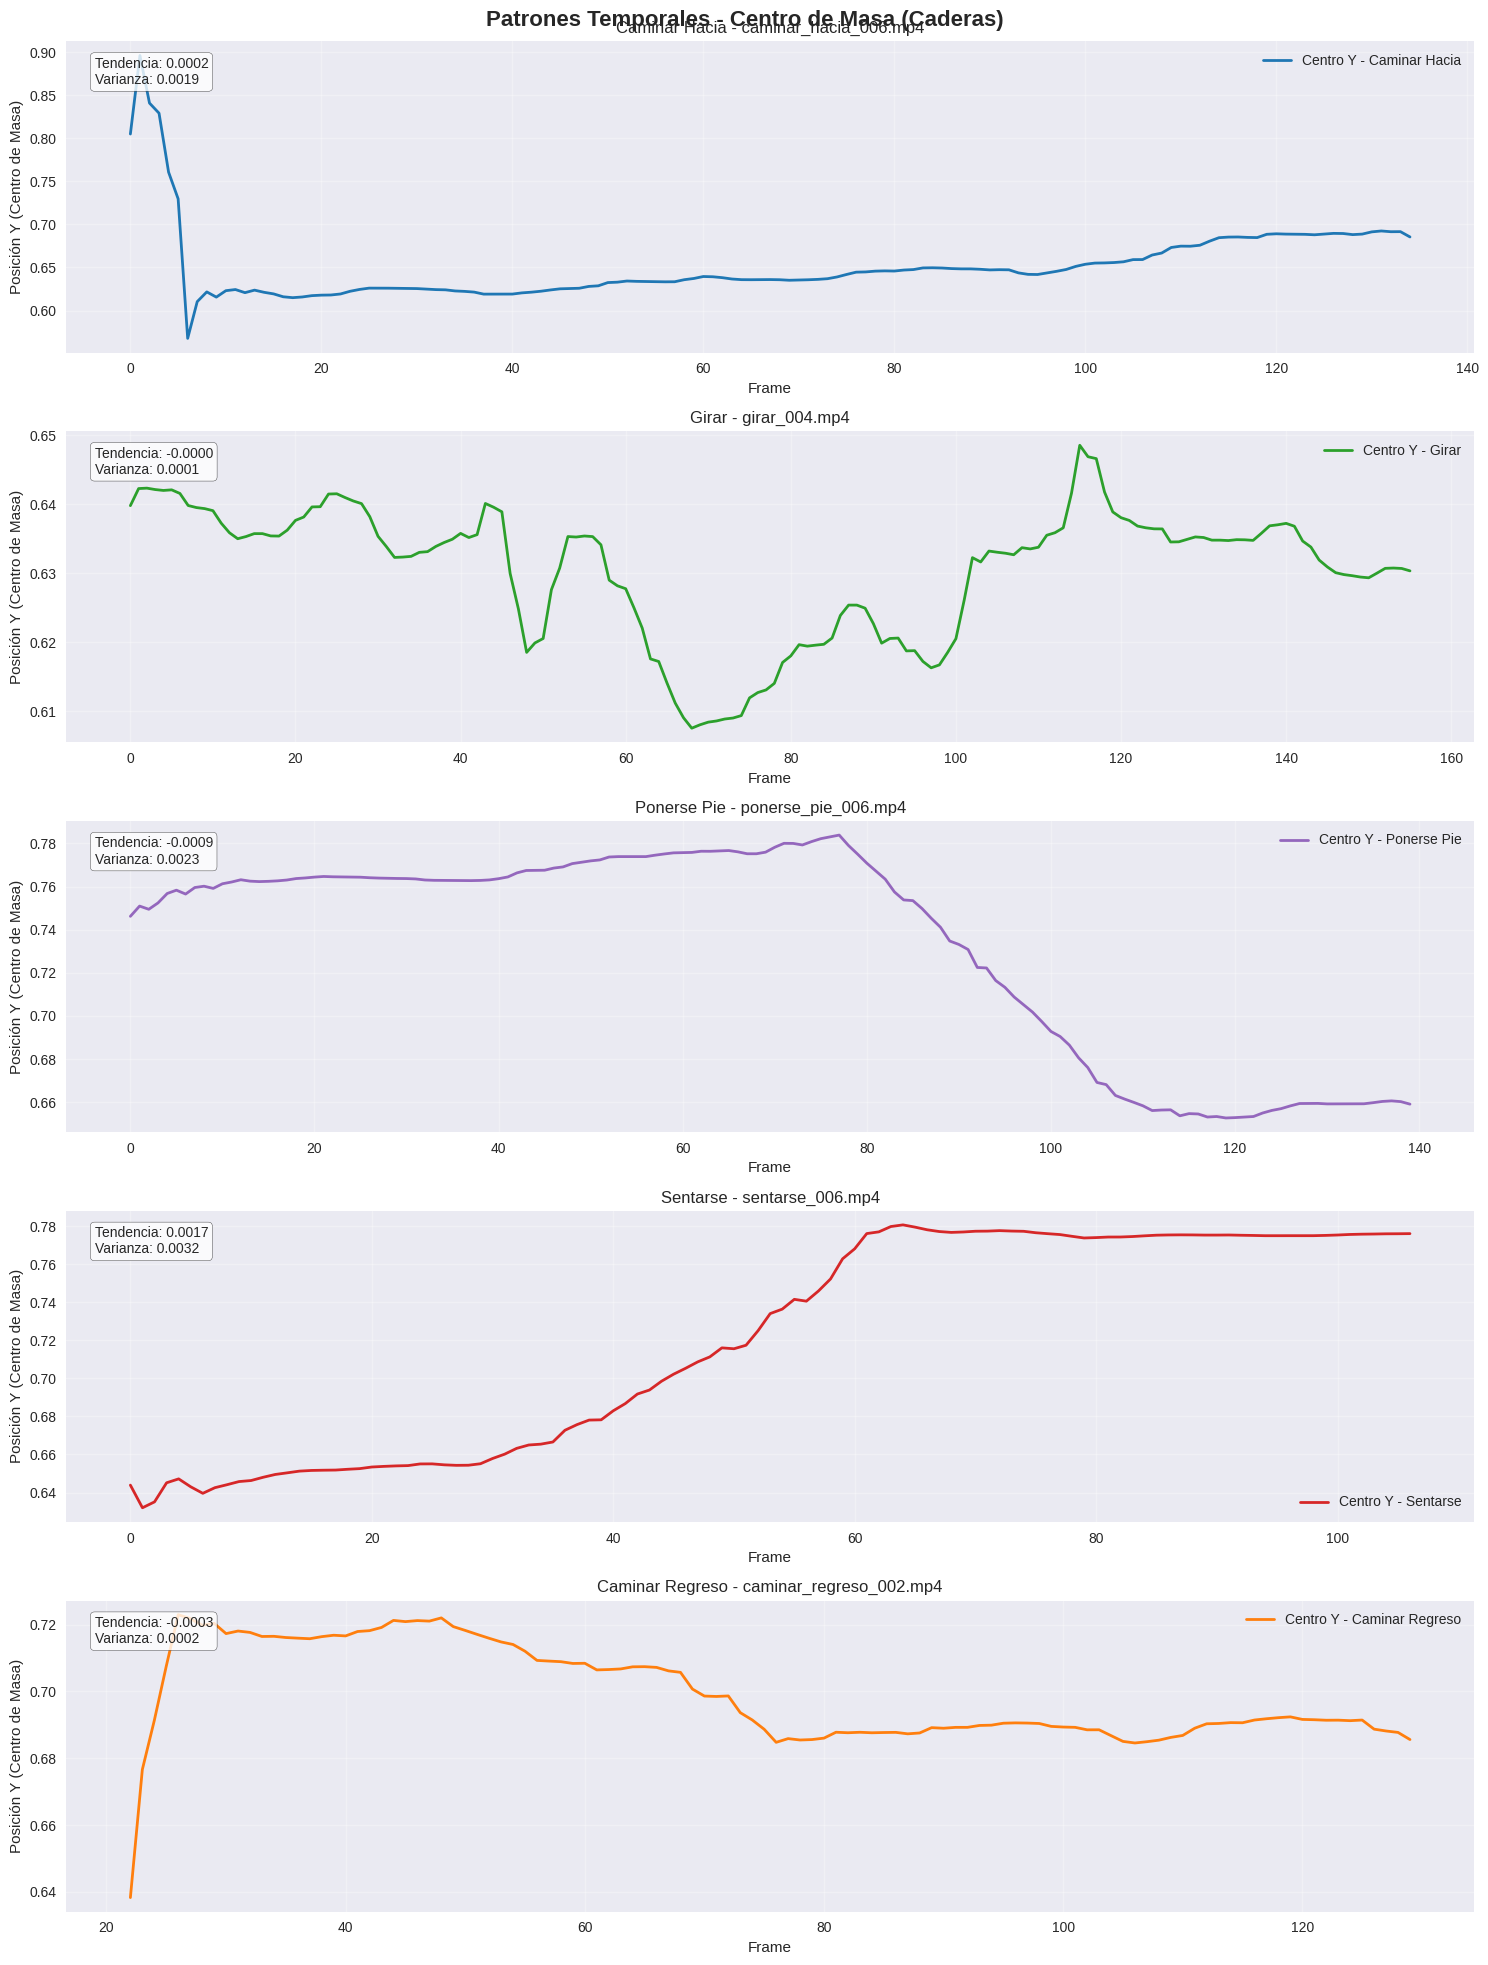


📈 ANÁLISIS DE PATRONES:
   Caminar Hacia:
      Posición promedio: 0.648
      Varianza: 0.002
      Rango movimiento: 0.356
   Girar:
      Posición promedio: 0.631
      Varianza: 0.000
      Rango movimiento: 0.067
   Ponerse Pie:
      Posición promedio: 0.729
      Varianza: 0.003
      Rango movimiento: 0.150
   Sentarse:
      Posición promedio: 0.725
      Varianza: 0.003
      Rango movimiento: 0.185
   Caminar Regreso:
      Posición promedio: 0.682
      Varianza: 0.002
      Rango movimiento: 0.232


In [12]:
# ANÁLISIS DE PATRONES TEMPORALES
def temporal_pattern_analysis(df):
    """Analizar patrones temporales de movimiento"""
    print("⏱️ ANÁLISIS DE PATRONES TEMPORALES")
    print("=" * 40)

    # Seleccionar un video ejemplo por actividad
    example_videos = {}
    for activity in df['activity'].unique():
        activity_videos = df[df['activity'] == activity]['video_file'].unique()
        if len(activity_videos) > 0:
            # Seleccionar video con más frames
            best_video = None
            max_frames = 0
            for video in activity_videos:
                video_frames = len(df[df['video_file'] == video])
                if video_frames > max_frames:
                    max_frames = video_frames
                    best_video = video
            example_videos[activity] = best_video

    # Crear visualización temporal
    fig, axes = plt.subplots(len(example_videos), 1, figsize=(15, 4*len(example_videos)))
    if len(example_videos) == 1:
        axes = [axes]

    fig.suptitle('Patrones Temporales - Centro de Masa (Caderas)', fontsize=16, fontweight='bold')

    activity_colors = {
        'caminar_hacia': '#1f77b4',
        'caminar_regreso': '#ff7f0e',
        'girar': '#2ca02c',
        'sentarse': '#d62728',
        'ponerse_pie': '#9467bd'
    }

    for i, (activity, video) in enumerate(example_videos.items()):
        video_data = df[df['video_file'] == video].copy()

        # Calcular centro de masa (promedio de caderas)
        if 'L_hip_y' in video_data.columns and 'R_hip_y' in video_data.columns:
            video_data['center_mass_y'] = (video_data['L_hip_y'] + video_data['R_hip_y']) / 2
            video_data['center_mass_x'] = (video_data['L_hip_x'] + video_data['R_hip_x']) / 2

            # Plotear evolución temporal
            axes[i].plot(video_data['frame_number'], video_data['center_mass_y'],
                        color=activity_colors.get(activity, 'gray'), linewidth=2,
                        label=f'Centro Y - {activity.replace("_", " ").title()}')

            axes[i].set_title(f'{activity.replace("_", " ").title()} - {video}')
            axes[i].set_xlabel('Frame')
            axes[i].set_ylabel('Posición Y (Centro de Masa)')
            axes[i].grid(True, alpha=0.3)
            axes[i].legend()

            # Estadísticas del patrón
            y_trend = np.polyfit(range(len(video_data)), video_data['center_mass_y'], 1)[0]
            y_variance = video_data['center_mass_y'].var()

            # Añadir texto con estadísticas
            axes[i].text(0.02, 0.95, f'Tendencia: {y_trend:.4f}\nVarianza: {y_variance:.4f}',
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('data/eda_results/patrones_temporales.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Análisis numérico de patrones
    print(f"\n📈 ANÁLISIS DE PATRONES:")

    pattern_stats = {}
    for activity in df['activity'].unique():
        activity_data = df[df['activity'] == activity]

        if 'L_hip_y' in activity_data.columns and 'R_hip_y' in activity_data.columns:
            center_y = (activity_data['L_hip_y'] + activity_data['R_hip_y']) / 2

            pattern_stats[activity] = {
                'mean_position': center_y.mean(),
                'variance': center_y.var(),
                'range': center_y.max() - center_y.min(),
                'total_frames': len(activity_data)
            }

            print(f"   {activity.replace('_', ' ').title()}:")
            print(f"      Posición promedio: {center_y.mean():.3f}")
            print(f"      Varianza: {center_y.var():.3f}")
            print(f"      Rango movimiento: {center_y.max() - center_y.min():.3f}")

    return pattern_stats

# Ejecutar análisis temporal
if df_landmarks is not None:
    temporal_stats = temporal_pattern_analysis(df)
else:
    print("❌ No hay datos para análisis temporal")


## Paso 8: Matriz de Correlación
Analizar correlaciones entre diferentes landmarks.


🔗 MATRIZ DE CORRELACIÓN ENTRE LANDMARKS
📊 Analizando correlaciones entre 12 variables


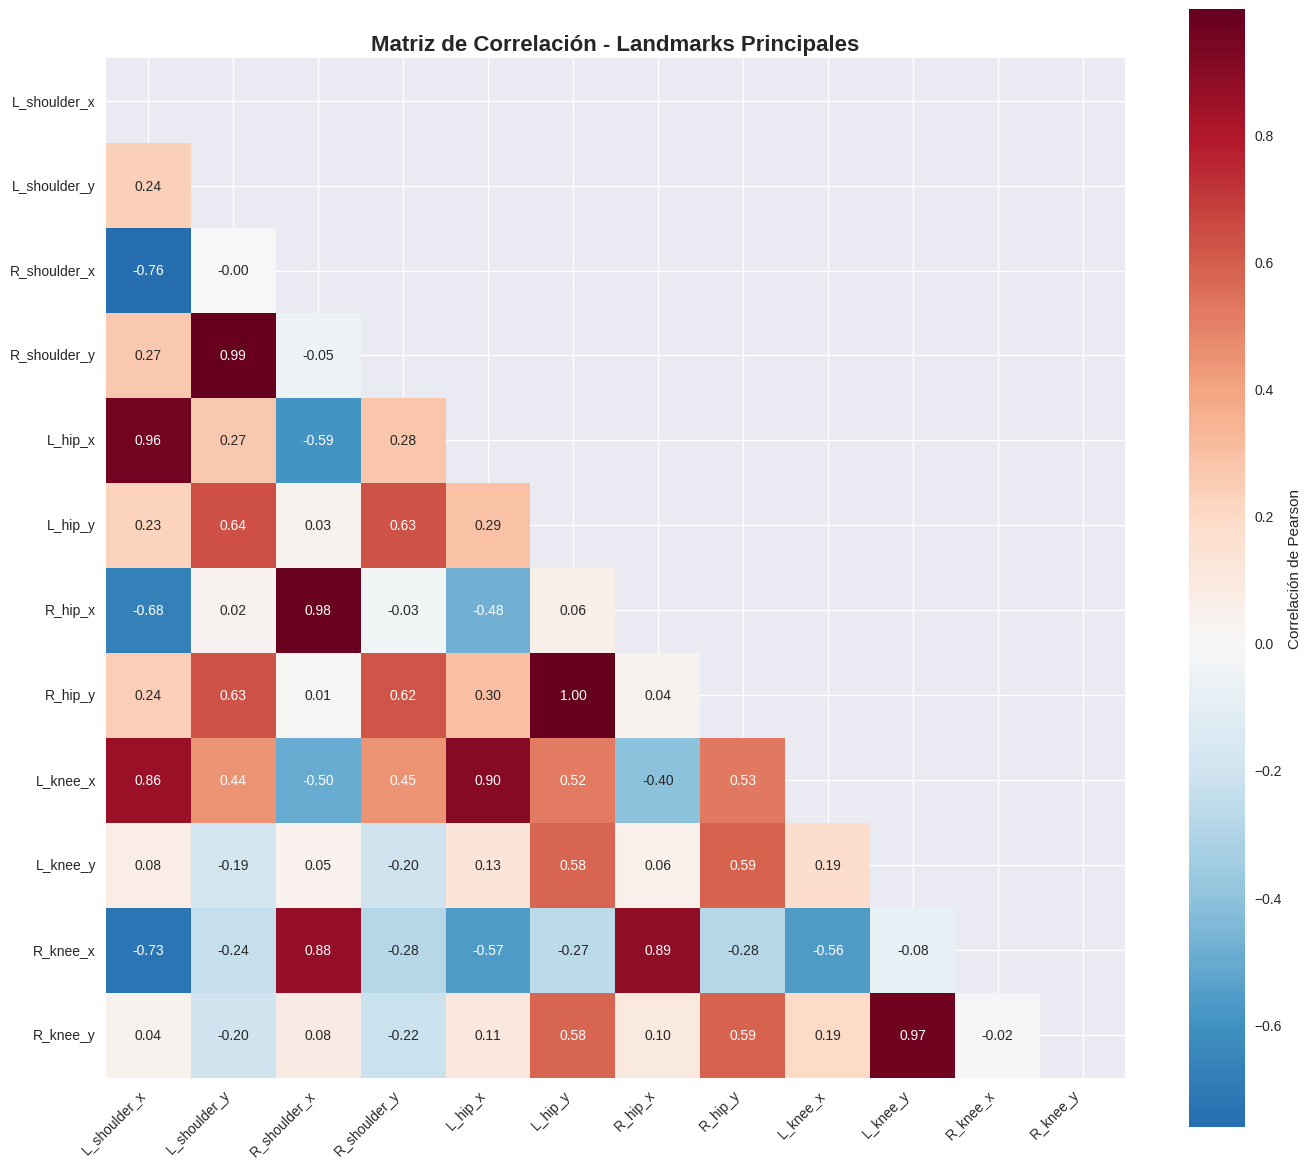


🔝 TOP 10 CORRELACIONES MÁS ALTAS:
    1. L_hip_y ↔ R_hip_y: 0.997
    2. L_shoulder_y ↔ R_shoulder_y: 0.994
    3. R_shoulder_x ↔ R_hip_x: 0.983
    4. L_knee_y ↔ R_knee_y: 0.967
    5. L_shoulder_x ↔ L_hip_x: 0.957
    6. L_hip_x ↔ L_knee_x: 0.903
    7. R_hip_x ↔ R_knee_x: 0.887
    8. R_shoulder_x ↔ R_knee_x: 0.879
    9. L_shoulder_x ↔ L_knee_x: 0.856
   10. L_shoulder_x ↔ R_shoulder_x: -0.761

🔻 TOP 5 CORRELACIONES MÁS BAJAS:
   1. L_hip_x ↔ L_hip_y: 0.292
   2. R_shoulder_y ↔ R_knee_x: -0.282
   3. R_hip_y ↔ R_knee_x: -0.281
   4. R_shoulder_y ↔ L_hip_x: 0.279
   5. L_hip_y ↔ R_knee_x: -0.272


In [13]:
# MATRIZ DE CORRELACIÓN ENTRE LANDMARKS
def correlation_analysis(df):
    """Analizar correlaciones entre landmarks"""
    print("🔗 MATRIZ DE CORRELACIÓN ENTRE LANDMARKS")
    print("=" * 50)

    # Seleccionar landmarks principales para correlación
    main_landmarks = ['L_shoulder', 'R_shoulder', 'L_hip', 'R_hip', 'L_knee', 'R_knee']
    correlation_cols = []

    for landmark in main_landmarks:
        for coord in ['x', 'y']:
            col_name = f"{landmark}_{coord}"
            if col_name in df.columns:
                correlation_cols.append(col_name)

    if not correlation_cols:
        print("❌ No se encontraron columnas para correlación")
        return None

    print(f"📊 Analizando correlaciones entre {len(correlation_cols)} variables")

    # Calcular correlaciones
    corr_matrix = df[correlation_cols].corr()

    # Crear heatmap
    plt.figure(figsize=(14, 12))

    # Máscara para mostrar solo triángulo inferior
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix,
                mask=mask,
                annot=True,
                cmap='RdBu_r',
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlación de Pearson'})

    plt.title('Matriz de Correlación - Landmarks Principales', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('data/eda_results/matriz_correlacion.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Encontrar correlaciones más altas
    correlations = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if not np.isnan(corr_val):
                correlations.append({
                    'var1': corr_matrix.columns[i],
                    'var2': corr_matrix.columns[j],
                    'correlation': corr_val
                })

    # Ordenar por valor absoluto
    correlations = sorted(correlations, key=lambda x: abs(x['correlation']), reverse=True)

    print(f"\n🔝 TOP 10 CORRELACIONES MÁS ALTAS:")
    for i, corr in enumerate(correlations[:10]):
        print(f"   {i+1:2d}. {corr['var1']} ↔ {corr['var2']}: {corr['correlation']:.3f}")

    print(f"\n🔻 TOP 5 CORRELACIONES MÁS BAJAS:")
    lowest_corr = [c for c in correlations if abs(c['correlation']) < 0.3]
    for i, corr in enumerate(lowest_corr[:5]):
        print(f"   {i+1}. {corr['var1']} ↔ {corr['var2']}: {corr['correlation']:.3f}")

    return corr_matrix

# Ejecutar análisis de correlación
if df_landmarks is not None:
    correlation_matrix = correlation_analysis(df)
else:
    print("❌ No hay datos para análisis de correlación")


## Paso 9: PCA - Reducción de Dimensionalidad
Aplicar PCA para identificar las componentes principales del movimiento.


🔍 ANÁLISIS PCA - COMPONENTES PRINCIPALES
📊 Columnas válidas para PCA: 64


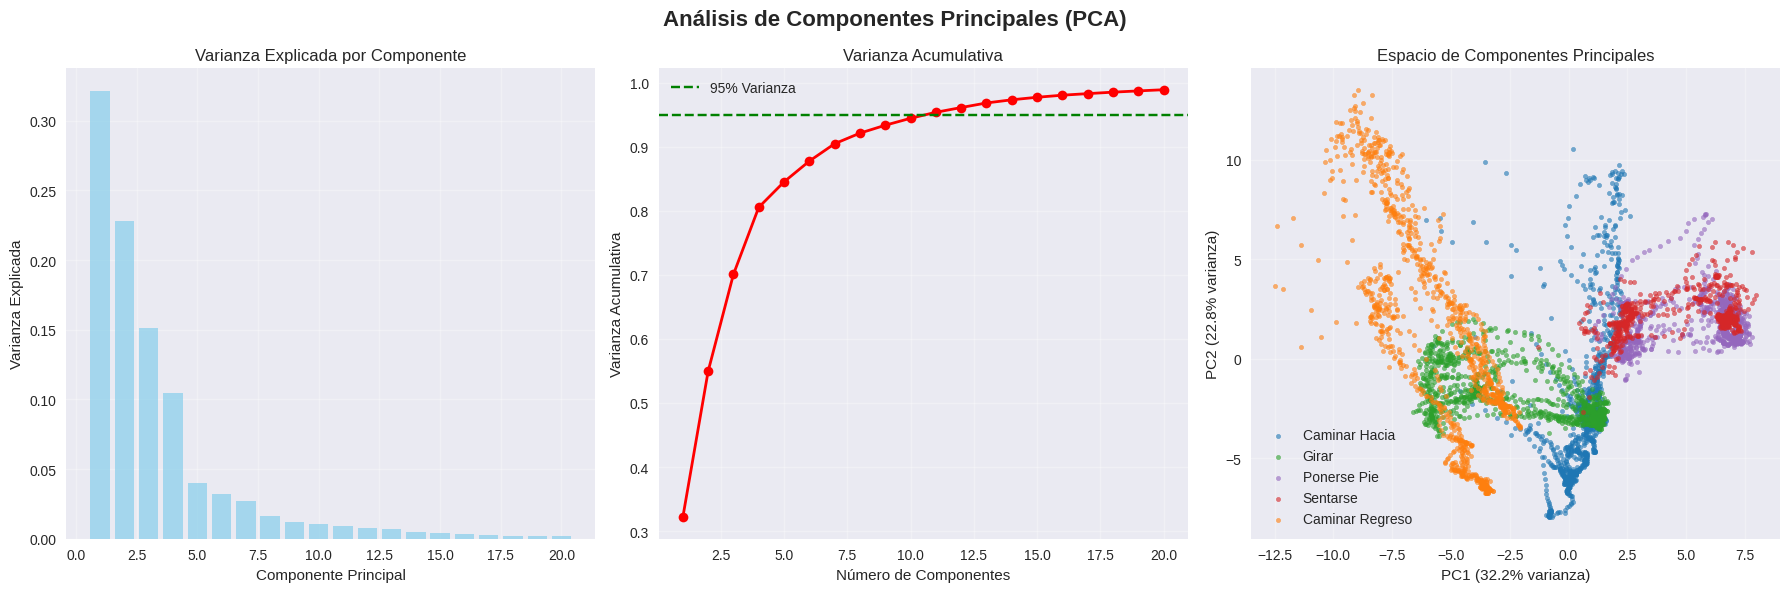


📊 RESULTADOS PCA:
   🎯 PC1 explica: 32.2% de la varianza
   🎯 PC2 explica: 22.8% de la varianza
   📈 PC1+PC2 explican: 54.9% total
   📊 Para 95% varianza: 11 componentes


In [14]:
# ANÁLISIS PCA - COMPONENTES PRINCIPALES
def pca_analysis(df):
    """Aplicar PCA para reducción de dimensionalidad"""
    print("🔍 ANÁLISIS PCA - COMPONENTES PRINCIPALES")
    print("=" * 50)

    # Preparar datos para PCA
    landmark_cols = [col for col in df.columns if col not in ['activity', 'video_file', 'frame_number']]

    # Eliminar columnas con solo ceros o NaN
    valid_cols = []
    for col in landmark_cols:
        if df[col].var() > 0 and not df[col].isna().all():
            valid_cols.append(col)

    print(f"📊 Columnas válidas para PCA: {len(valid_cols)}")

    if len(valid_cols) < 2:
        print("❌ No hay suficientes columnas válidas para PCA")
        return None

    # Preparar matriz de datos
    X = df[valid_cols].fillna(0)  # Rellenar NaN con 0

    # Standardizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Aplicar PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Crear visualizaciones
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Análisis de Componentes Principales (PCA)', fontsize=16, fontweight='bold')

    # 1. Varianza explicada
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    axes[0].bar(range(1, min(21, len(explained_var)+1)), explained_var[:20], alpha=0.7, color='skyblue')
    axes[0].set_title('Varianza Explicada por Componente')
    axes[0].set_xlabel('Componente Principal')
    axes[0].set_ylabel('Varianza Explicada')
    axes[0].grid(True, alpha=0.3)

    # 2. Varianza acumulativa
    axes[1].plot(range(1, min(21, len(cumulative_var)+1)), cumulative_var[:20],
                marker='o', linewidth=2, color='red')
    axes[1].axhline(y=0.95, color='green', linestyle='--', label='95% Varianza')
    axes[1].set_title('Varianza Acumulativa')
    axes[1].set_xlabel('Número de Componentes')
    axes[1].set_ylabel('Varianza Acumulativa')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # 3. Scatter plot PC1 vs PC2 por actividad
    activity_colors = {
        'caminar_hacia': '#1f77b4',
        'caminar_regreso': '#ff7f0e',
        'girar': '#2ca02c',
        'sentarse': '#d62728',
        'ponerse_pie': '#9467bd'
    }

    for activity in df['activity'].unique():
        activity_mask = df['activity'] == activity
        axes[2].scatter(X_pca[activity_mask, 0], X_pca[activity_mask, 1],
                       c=activity_colors.get(activity, 'gray'),
                       label=activity.replace('_', ' ').title(),
                       alpha=0.6, s=10)

    axes[2].set_title('Espacio de Componentes Principales')
    axes[2].set_xlabel(f'PC1 ({explained_var[0]*100:.1f}% varianza)')
    axes[2].set_ylabel(f'PC2 ({explained_var[1]*100:.1f}% varianza)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('data/eda_results/pca_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Estadísticas PCA
    print(f"\n📊 RESULTADOS PCA:")
    print(f"   🎯 PC1 explica: {explained_var[0]*100:.1f}% de la varianza")
    print(f"   🎯 PC2 explica: {explained_var[1]*100:.1f}% de la varianza")
    print(f"   📈 PC1+PC2 explican: {(explained_var[0]+explained_var[1])*100:.1f}% total")

    # Componentes necesarias para 95% de varianza
    components_95 = np.where(cumulative_var >= 0.95)[0]
    if len(components_95) > 0:
        n_comp_95 = components_95[0] + 1
        print(f"   📊 Para 95% varianza: {n_comp_95} componentes")

    return {
        'pca_model': pca,
        'scaler': scaler,
        'explained_variance': explained_var,
        'cumulative_variance': cumulative_var,
        'n_components_95': n_comp_95 if len(components_95) > 0 else len(explained_var)
    }

# Ejecutar PCA
if df_landmarks is not None:
    pca_results = pca_analysis(df)
else:
    print("❌ No hay datos para PCA")


## Paso 10: Resumen Ejecutivo
Ver análisis completo del EDA en el archivo de documentación.


📋 **ANÁLISIS COMPLETO DISPONIBLE EN:** `docs/analisis_eda.md`

### Contenido del análisis:
- 📊 Resumen ejecutivo con estadísticas clave
- 🎯 Análisis detallado por actividad  
- 📈 Evaluación de calidad de detección MediaPipe
- 🔍 Interpretación de patrones temporales
- 🔗 Análisis de correlaciones entre landmarks
- 📊 Resultados de PCA y reducción dimensional
- 💡 Recomendaciones para modelado ML
- 📋 Métricas de evaluación del dataset

### Archivos de visualización:
- `distribucion_dataset.png`
- `landmarks_por_actividad.png`
- `patrones_temporales.png`
- `matriz_correlacion.png`
- `pca_analysis.png`
